In [1]:
import datetime
from itertools import zip_longest
import pathlib


import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from utils import powerset


#### Visualize New Features

In [2]:
root_dir = pathlib.Path("../data")
dir_2018 = root_dir/"311/2018"
df = pd.read_parquet(dir_2018/"processed")
df = df[df['created_H']>=datetime.date(2018,1,1)]


In [3]:
target_df = df[['created_H','agency', 'hours_to_complete']] \
        .groupby(['created_H','agency']) \
                .mean().unstack('agency')
# axes = target_df.plot(
#         # x='created_H',
#         # y='hours_to_complete',
#         title='Hours to Complete over time by Agency',
#         legend=True,
#         subplots=True,
#         ylim=[0,1000]
#         )
# fig = axes[0].get_figure()
# fig.set_size_inches((40,100))


C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\1936376220.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['created_H','agency']) \


In [4]:
# target_ct_df = df[['created_H','complaint_type', 'hours_to_complete']] \
#         .groupby(['created_H','complaint_type']) \
#                 .mean().unstack('complaint_type')
# axes = target_ct_df.plot(
#         # x='created_H',
#         # y='hours_to_complete',
#         title='Hours to Complete Over Time by Complaint Type',
#         legend=True,
#         subplots=True
#         )
# fig = axes[0].get_figure()
# fig.set_size_inches((40,100))


In [5]:
def get_highest_correlation_to_feat(
    df:pd.DataFrame,
    target:str,
    features:list[str],
    min_corr:float=0.3 # minimum absolute correlation to be added to the dict
    ):
    # row key: [correlation, y_column, [x_columns]]
    high_corr = {}
    for col_names in powerset(features):
        if col_names == ():
            continue
        trunc_name = '_'.join([target]+[name[:2] for name in col_names])
        if trunc_name not in df.columns:
            continue
        col_names = list(col_names)
        # get the correlation between completion time and number open for high freq
        consider_df = df.groupby(col_names)[['hours_to_complete',trunc_name]]
        correlation:pd.DataFrame = consider_df.corr()
        correlation.drop(trunc_name, axis=1, inplace=True)
        correlation.reset_index(level=-1, drop=True, inplace=True)
        abs_correlation = correlation['hours_to_complete'].abs().iloc[1::2]
        hcorr:pd.Series = abs_correlation[(abs_correlation<1)&(abs_correlation>min_corr)]

        # add to dict if no subset of features is in the dict already
        for n, v in hcorr.items():
            tdic = {k:v for k, v in zip(col_names, n)}
            if consider_df.get_group(n)['hours_to_complete'].count() < 1000:
                continue
            if 'complaint_type' in tdic and tdic['complaint_type'] in high_corr:
                continue
            if n not in high_corr:
                high_corr[n] = [v, trunc_name, col_names]
            else:
                high_corr[n] = max(high_corr[n], [v, trunc_name, col_names])
    return high_corr
# select complaint types whose completion time is dependent on number of open requests
# high_freq_df = high_freq_df[high_freq_df['complaint_type'].isin(high_corr)]




In [6]:
# average completion time
# completion_time_by_type = df.groupby('complaint_type')['hours_to_complete'].mean()
# binning completion time
# q2, bins = pd.qcut(completion_time_by_type[completion_time_by_type.index.isin(candidates)], 3, labels=bin_lbls, retbins=True,duplicates='raise')


# number of complaint types
num_of_type = df.groupby('complaint_type')['complaint_type'].value_counts()

bin_lbls = ['Low','Mid','High']
# binning freqency of complaint
q1, bins = pd.qcut(num_of_type, 3, labels=bin_lbls, retbins=True,duplicates='raise')
candidates = q1[q1=='High'].index

# get high frequency records
high_freq_df = df[(df['created_date']>df['created_date'].median())&(df['complaint_type'].isin(candidates))]

# remove outlier records
quants_df = high_freq_df.groupby('complaint_type')['hours_to_complete'].quantile([0.25,0.75])
quants_df = quants_df.unstack()
out_max = (quants_df[0.75] - quants_df[0.25])*2
# quants_df.columns
high_freq_df = pd.merge(high_freq_df, out_max.rename('upper_bound'), left_on='complaint_type', right_index=True)
high_freq_df = high_freq_df[high_freq_df['hours_to_complete'] < high_freq_df['upper_bound']]
high_freq_df.drop('upper_bound', axis=1, inplace=True)

# get high correlation to number open
s = ['borough', 'agency', 'complaint_type']
high_corr_open = get_highest_correlation_to_feat(high_freq_df, 'open', s)

C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\241380098.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consider_df = df.groupby(col_names)[['hours_to_complete',trunc_name]]
C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\241380098.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consider_df = df.groupby(col_names)[['hours_to_complete',trunc_name]]


In [7]:
high_corr_created = get_highest_correlation_to_feat(high_freq_df, 'created', s)
high_corr_created

C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\241380098.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consider_df = df.groupby(col_names)[['hours_to_complete',trunc_name]]
C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\241380098.py:17: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  consider_df = df.groupby(col_names)[['hours_to_complete',trunc_name]]


{'Broken Parking Meter': [0.469427668530258, 'created_co', ['complaint_type']],
 ('BRONX', 'DSNY'): [0.3657891812388905,
  'created_bo_ag',
  ['borough', 'agency']],
 ('BROOKLYN', 'DSNY'): [0.3036554356647592,
  'created_bo_ag',
  ['borough', 'agency']],
 ('QUEENS', 'TLC'): [0.3097842209616508,
  'created_bo_ag',
  ['borough', 'agency']],
 ('STATEN ISLAND', 'DPR'): [0.3345281553613522,
  'created_bo_ag',
  ['borough', 'agency']],
 ('BROOKLYN', 'Lead'): [0.3332146392971173,
  'created_bo_co',
  ['borough', 'complaint_type']]}

In [8]:
high_corr_open

{'DOF Property - Reduction Issue': [0.3938962809283435,
  'open_co',
  ['complaint_type']],
 'DOF Property - Update Account': [0.38814849757931985,
  'open_co',
  ['complaint_type']],
 'Graffiti': [0.37107288181535336, 'open_co', ['complaint_type']],
 'Housing - Low Income Senior': [0.42276845143694225,
  'open_co',
  ['complaint_type']],
 'Lead': [0.3726795092100528, 'open_co', ['complaint_type']],
 'Literature Request': [0.30244261239022197, 'open_co', ['complaint_type']],
 'SCRIE': [0.6569636611755264, 'open_co', ['complaint_type']],
 ('MANHATTAN', 'HPD'): [0.3450379682575227,
  'open_bo_ag',
  ['borough', 'agency']],
 ('BROOKLYN', 'Special Projects Inspection Team (SPIT)'): [0.3422995946032217,
  'open_bo_co',
  ['borough', 'complaint_type']],
 ('MANHATTAN', 'Broken Parking Meter'): [0.3668140373590075,
  'open_bo_co',
  ['borough', 'complaint_type']]}

C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\3521130824.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = high_freq_df.groupby(c).get_group(n)
C:\Users\Morri\AppData\Local\Temp\ipykernel_16092\3521130824.py:49: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = high_freq_df.groupby(c).get_group(n)


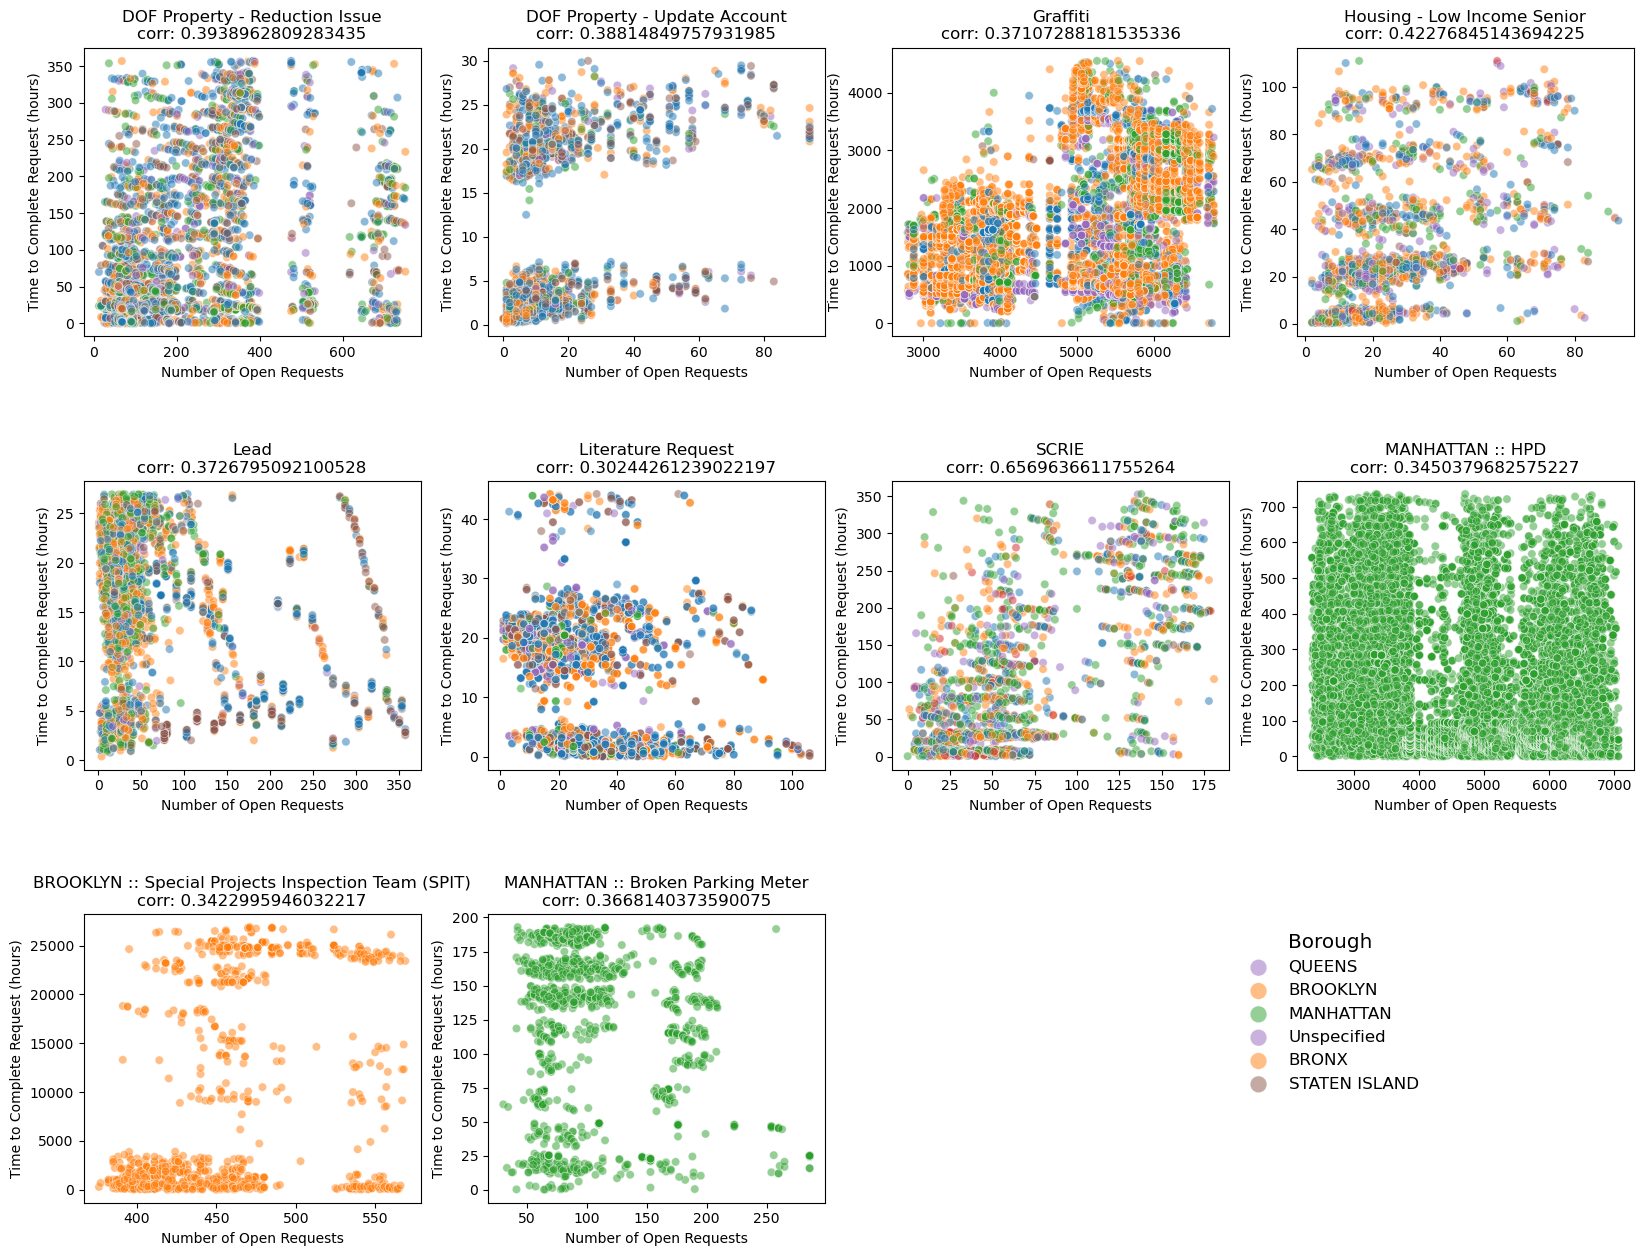

In [9]:
final_set = []
corr_nums = set()
# graph hexbins for high corr, high frequency complaint types
for n, (corr, x, c) in high_corr_open.items():
    if corr not in corr_nums:
        corr_nums.add(corr)
    else:
        continue
    try:
        grp = high_freq_df.groupby(c).get_group(n)
    except KeyError:
        continue
    if isinstance(n, tuple):
        name = ' :: '.join(n)
    else:
        name = n

    title = f'{name}\ncorr: {corr}'
    final_set.append((n,title, x, c))

def nearest_rectangle(num_vars:int):
    length = width = round(num_vars**0.5)

    if length * width < num_vars:
        width += 1

    return length, width

height, width = nearest_rectangle(len(final_set))

boroughs = list(df['borough'].unique())
borough_colors = {b:c for b,c in zip(boroughs, plt.cm.rainbow(np.linspace(0, 1, len(boroughs))))}


fig, axes = plt.subplots(
            nrows=height,
            ncols=width,
            squeeze=False
            # subplot_titles=subplot_titles
        )


fig.set_size_inches(20,15)
plt.subplots_adjust(hspace=0.5)
for (i, ax), (n, title, x, c) in zip_longest(np.ndenumerate(axes), final_set, fillvalue=('_','_','_','_')):
    if n == '_':
        ax.set_axis_off()
        continue
    grp = high_freq_df.groupby(c).get_group(n)
    sns.scatterplot(
        y='hours_to_complete',
        x=x,
        hue='borough',
        hue_order=borough_colors,
        data=grp,
        alpha=0.5,
        ax = ax,
        legend=False,
        )
    ax.set_xlabel("Number of Open Requests")
    ax.set_ylabel('Time to Complete Request (hours)')
    ax.set_title(title)




leg = fig.legend(
    labels=boroughs,
    # handles=handles,
    bbox_to_anchor=[.3,-.2,0.5,0.5],
    fontsize='large',
    markerscale=2,
    frameon=False,
    title="Borough",
    title_fontsize='x-large',
    draggable=True
    )




<Axes: title={'center': 'Open Requests by Hour by Borough'}, xlabel='created_H'>

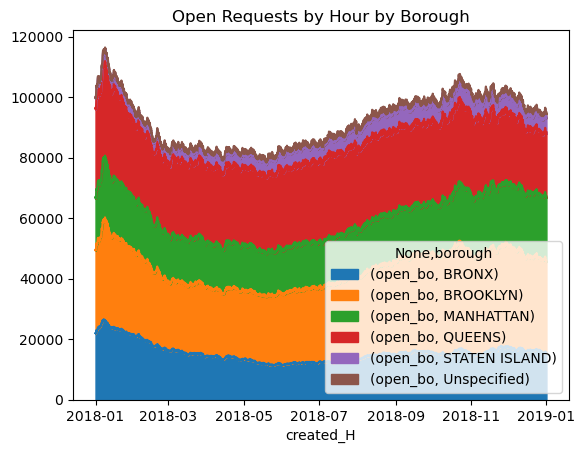

In [10]:
borough_df = df[['created_H','borough', 'open_bo']].groupby(['created_H','borough']).max().unstack().ffill().fillna(0)
borough_df.plot.area(
        title='Open Requests by Hour by Borough',
        )

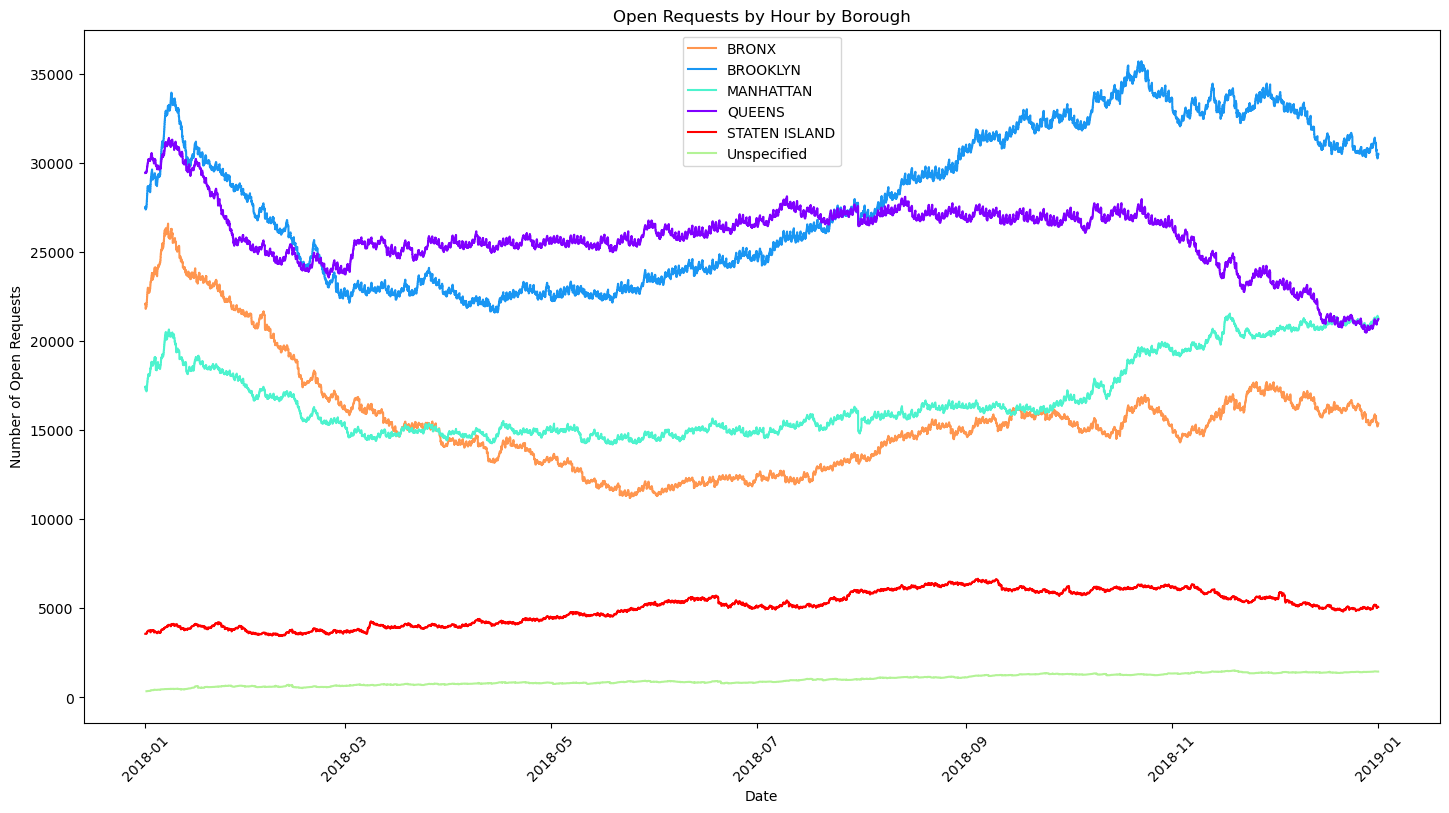

In [11]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))
# graph number of open requests by borough for the sample
for n, grp in df.groupby(['borough']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_bo'] = grp['open_bo'].ffill().fillna(0)
    grp.plot(
        x='created_date', y='open_bo',
        title='Open Requests by Hour by Borough',
        legend=True, ax=ax, c=borough_colors[n[0]],
        label=n[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Open Requests')
ax.tick_params(axis='x',rotation=45)


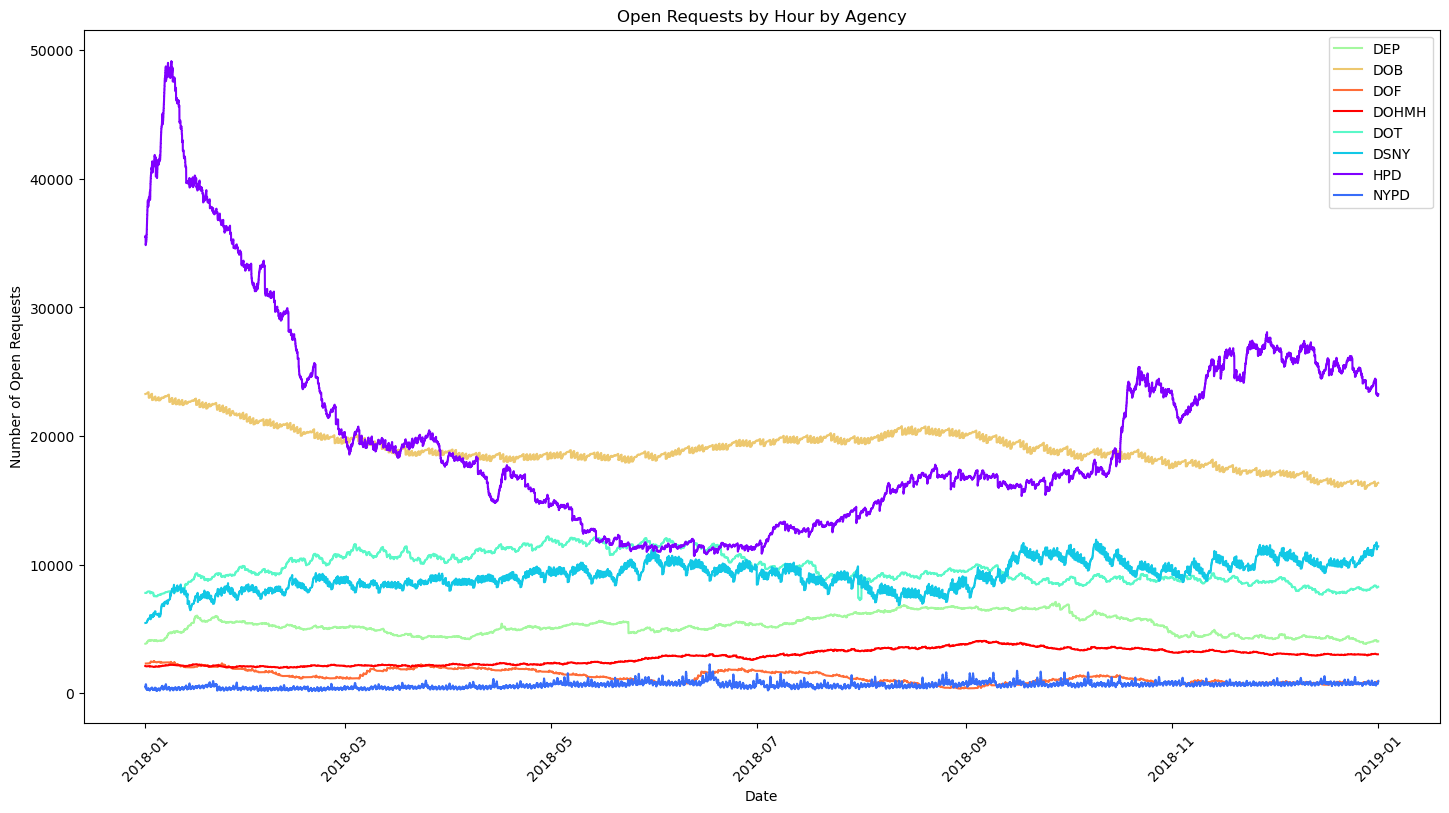

In [12]:

# graph number of open requests by agency for the sample
# df[df['open_bo']>0].groupby('borough').plot(x='created_date', y='open_bo')
high_freq = ['HPD', 'NYPD', 'DSNY', 'DOT', 'DEP', 'DOB', 'DOF', 'DOHMH']

agency_colors = {b:c for b,c in zip(high_freq, plt.cm.rainbow(np.linspace(0, 1, len(high_freq))))}


fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))

# graph number of open requests by borough for the sample
for n, grp in df[df['agency'].isin(high_freq)].groupby(['agency'], observed=True):
    # forward fill for missing days and fill first day w/ 0
    grp['open_ag'] = grp['open_ag'].ffill().fillna(0)
    grp.plot(
        x='created_date', y='open_ag',
        title='Open Requests by Hour by Agency',
        legend=True, ax=ax, c=agency_colors[n[0]],
        label=n[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Open Requests')
ax.tick_params(axis='x',rotation=45)


In [13]:
df

,borough,complaint_type,created_H,closed_H,created_date,closed_date,descriptor,status,resolution_description,resolution_action_updated_date,...,created_co,created_bo_ag,created_bo_co,open,open_bo,open_ag,open_co,open_bo_ag,open_bo_co,agency
367,QUEENS,Consumer Complaint,2018-01-01 08:00:00,2018-01-04 11:00:00,2018-01-01 08:20:58,2018-01-04 11:34:37,Non-Delivery Goods/Services,Closed,"Unfortunately, the behavior that you complaine...",2018-01-04 11:34:37,...,1,1,1,100230,29492,350,332,91,91,DCA
368,QUEENS,Consumer Complaint,2018-01-01 10:00:00,2018-01-17 01:00:00,2018-01-01 10:52:03,2018-01-17 01:06:13,Non-Delivery Goods/Services,Closed,The Department of Consumer Affairs mailed you ...,2018-01-17 01:06:13,...,1,1,1,100979,29615,351,333,92,92,DCA
369,QUEENS,Consumer Complaint,2018-01-01 11:00:00,2018-01-03 14:00:00,2018-01-01 11:25:49,2018-01-03 14:04:23,Unlicensed,Closed,The Department of Consumer Affairs is scheduli...,2018-01-03 14:04:23,...,1,1,1,101429,29681,352,334,93,93,DCA
370,BROOKLYN,Consumer Complaint,2018-01-01 12:00:00,2018-01-17 01:00:00,2018-01-01 12:18:36,2018-01-17 01:06:14,Damaged/Defective Goods,Closed,The Department of Consumer Affairs mailed you ...,2018-01-17 01:06:14,...,1,1,1,101898,28155,353,335,91,91,DCA
371,BROOKLYN,Consumer Complaint,2018-01-01 14:00:00,2018-01-17 01:00:00,2018-01-01 14:20:42,2018-01-17 01:06:15,Exchange/Refund/Return,Closed,The Department of Consumer Affairs mailed you ...,2018-01-17 01:06:15,...,4,2,2,102677,28409,357,339,93,93,DCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2704382,QUEENS,For Hire Vehicle Complaint,2018-12-31 22:00:00,2019-03-27 16:00:00,2018-12-31 22:08:33,2019-03-27 16:38:43,Driver Complaint,Closed,The Taxi and Limousine Commission was unable t...,2019-03-27 16:38:43,...,3,2,2,94740,21190,7655,3469,1132,501,TLC
2704383,QUEENS,For Hire Vehicle Complaint,2018-12-31 22:00:00,2019-05-21 18:00:00,2018-12-31 22:53:58,2019-05-21 18:56:04,Driver Complaint,Closed,The Taxi and Limousine Commission (TLC) called...,2019-05-21 18:56:04,...,3,2,2,94740,21190,7655,3469,1132,501,TLC
2704384,MANHATTAN,For Hire Vehicle Complaint,2018-12-31 23:00:00,2019-02-27 13:00:00,2018-12-31 23:46:36,2019-02-27 13:51:59,Driver Complaint,Closed,The Taxi and Limousine Commission was unable t...,2019-02-27 13:51:59,...,2,2,1,94966,21300,7658,3471,4528,1779,TLC
2704385,MANHATTAN,Taxi Complaint,2018-12-31 23:00:00,2019-05-22 07:00:00,2018-12-31 23:44:55,2019-05-22 07:25:05,Driver Complaint,Closed,A representative from the Taxi and Limousine C...,2019-05-22 07:25:05,...,1,2,1,94966,21300,7658,4060,4528,2651,TLC


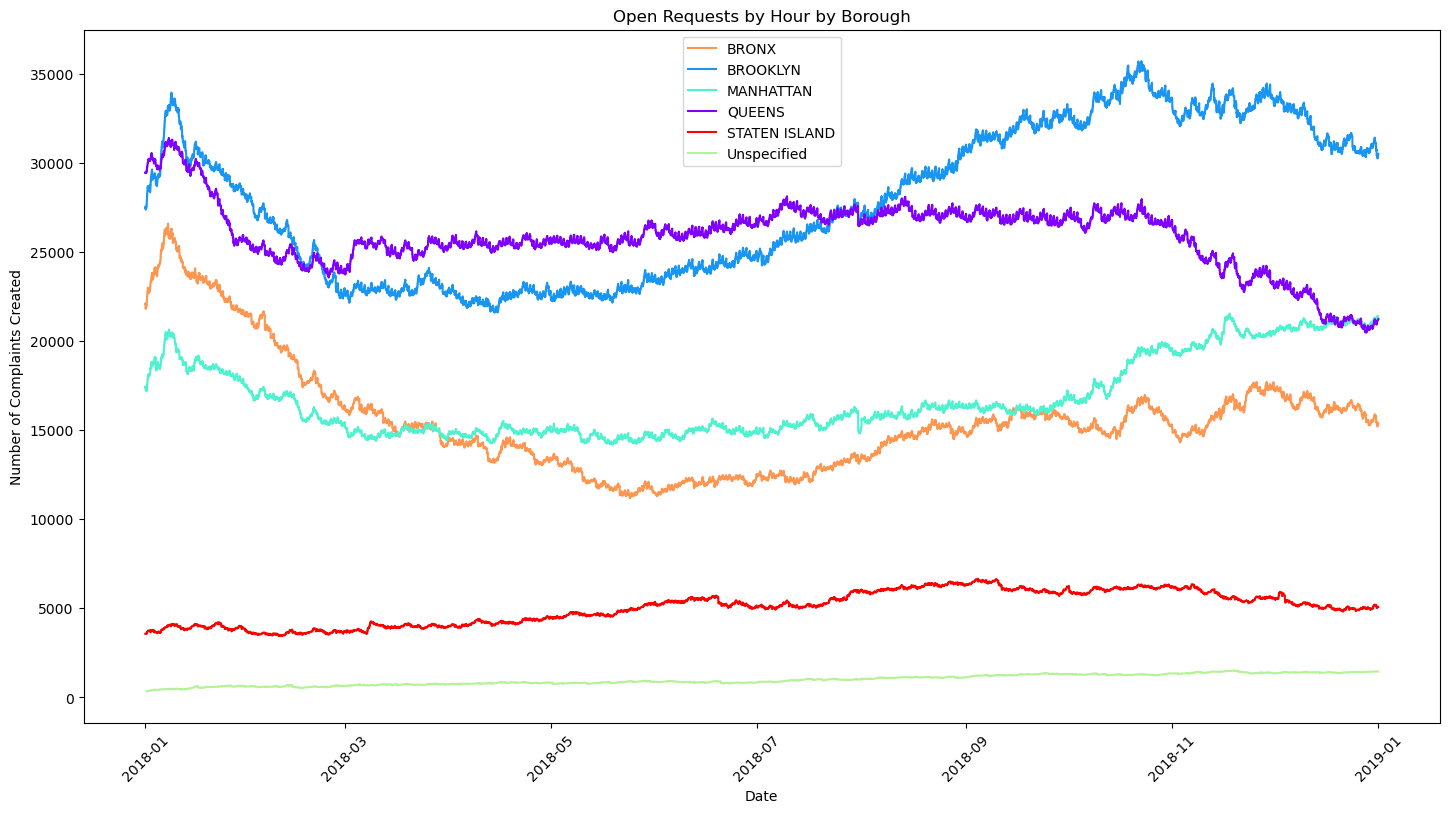

In [14]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))
# graph number of open requests by borough for the sample
for n, grp in  df.groupby(['borough']):
    # forward fill for missing days and fill first day w/ 0
    grp['open_bo'] = grp['open_bo'].fillna(0)
    grp.plot(
        x='created_date', y='open_bo',
        title='Open Requests by Hour by Borough',
        legend=True, ax=ax,
        c=borough_colors[n[0]],
        label=n[0])
ax.set_xlabel('Date')
ax.set_ylabel('Number of Complaints Created')
ax.tick_params(axis='x',rotation=45)

AttributeError: 'AreaPlot' object has no attribute 'columns'

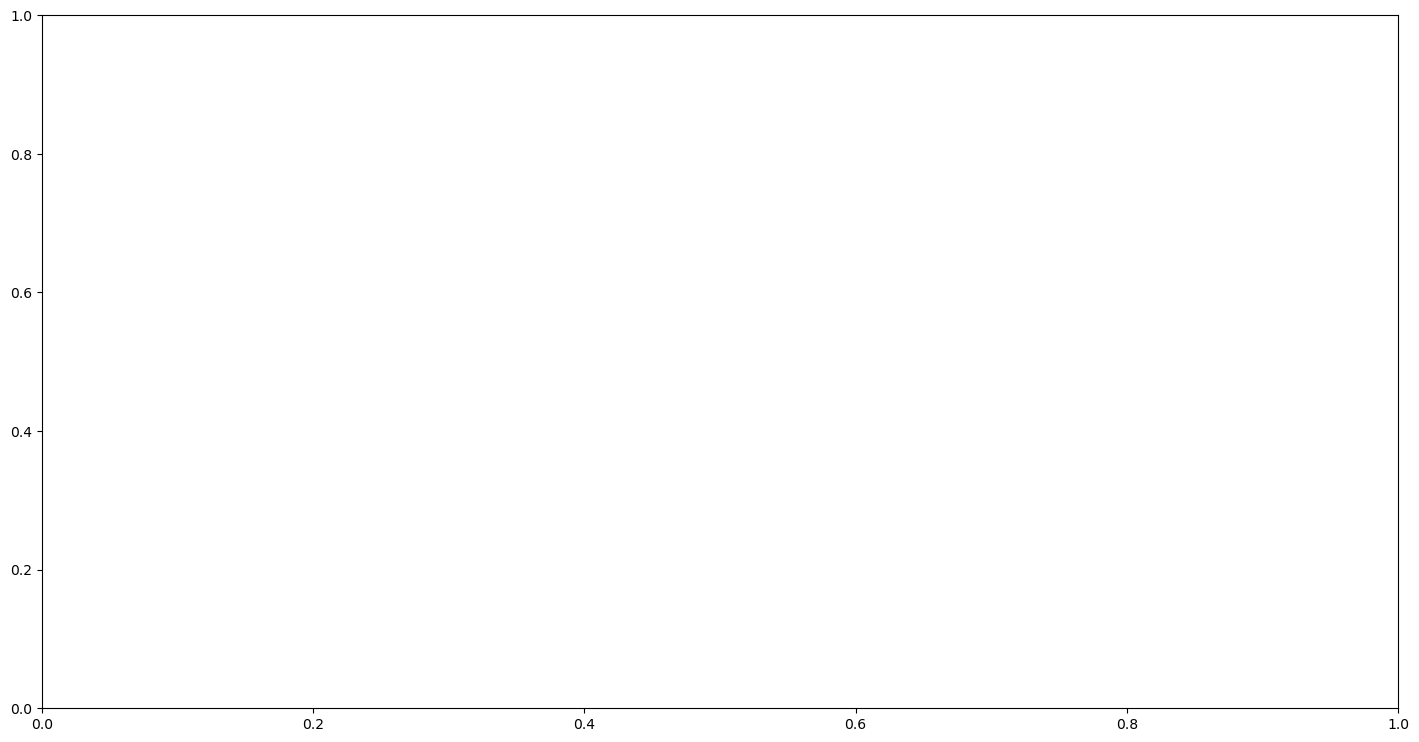

In [18]:
fig, ax = plt.subplots(1,1)
fig.set_size_inches((17.5,9))

# graph number of open requests by borough for the sample
# for n, grp in df.groupby(['borough']):
#     # forward fill for missing days and fill first day w/ 0
#     grp['created_bo'] = grp['created_bo'].fillna(0)
df.plot.area(stacked=True, cmap=plt.cm.RdGy,
        x='created_date', y='created_bo',
        title='Created Requests by Hour by Borough',
        legend=True, ax=ax,
        by='borough'
        # c=borough_colors[n[0]],
        # label=n[0]
        )
ax.set_xlabel('Date')
ax.set_ylabel('Number of Complaints Created')
ax.tick_params(axis='x',rotation=45)